# CE-40959: Advanced Machine Learning
## HW2 - Optimization-based Meta Learning (100 points)

#### Name: Mohammad Mozafari
#### Student No.: 400201167

In this notebook, you are going to implement a optimization-based meta learner using the `Omniglot` dataset.

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the Quera.

Also, it is recommended to use Google Colab to do this homework. You can connect to your drive using the code below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Required libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import random
import torch.nn as nn
import math

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

from copy import deepcopy

## Introduction

In Meta-Learning literature and in the meta-training phase, you are given some batches which consist of `support` and `query` sets. you train your model in a way that by using a support set you could predict query set labels correctly.

The pioneer of this branch is Model-Agnostic Meta-Learning(MAML). 

First, we should build the dataset in this way that each batch returns N*(k+k') images. `k` is the number of support images per class and `k'` is the number of query images per class in a batch.

The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

Train and test dataset contains 964 and 659 classes, respectively. Torchvision-based Omniglot dataset is ordered and every 20 images in a row belong to one class.

In [30]:
# Meta learning parameters.

N = 5
support_size = 1
query_size = 15
meta_inner_lr = 0.4
meta_outer_lr = 0.001

## Prepare dataset (5 points)

In [31]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = True, transform = transform)
test_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = False, transform = transform)

train_labels = np.repeat(np.arange(964), 20)
test_labels = np.repeat(np.arange(659), 20)

Files already downloaded and verified
Files already downloaded and verified


To build a dataloader, we should have a class that yields indexes of selected data in the dataset for every iteration and pass it to the `batch_sampler` attribute of dataloader.

Complete below code based on this pseudocode:


1.   select `N` classes randomly from all classes
2.   select `support_size + query_size` images from each classes independently and randomly
3.   shuffle dataset indexes, but don't forget to put query indexes at the last of the list

In [32]:
class BatchSampler(object):
    '''
    BatchSampler: yield a batch of indexes at each iteration.
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, support_size, query_size, iterations, batch_size):
        '''
        Initialize the BatchSampler object
        Args:
        - labels: array of labels of dataset.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class
        - iterations: number of iterations (episodes) per epoch
        - batch_size: number of batches per iteration
        '''
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.support_size = support_size
        self.query_size = query_size
        self.iterations = iterations
        self.batch_size = batch_size

    def __iter__(self):
        '''
        yield a batch of indexes
        '''

        for it in range(self.iterations):
            total_batch_indexes = np.array([])

            #################################################################################
            #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
            #################################################################################
            # feel free to add/edit initialization part of sampler.
            #################################################################################
            
            unique_labels = np.unique(self.labels)
            for _ in range(self.batch_size):
                random_classes = np.random.choice(unique_labels, size=N, replace=False)
                support_seq = np.array([])
                query_seq = np.array([])
                for i, c in enumerate(random_classes):
                    count = self.support_size + self.query_size
                    random_indices = np.random.choice(np.arange(20*c, 20*c+20), size=count, replace=False)
                    # support_seq[i*self.support_size:(i+1)*self.support_size] = random_indices[:self.support_size]
                    # query_seq[i*self.query_size:(i+1)*self.query_size] = random_indices[self.support_size:]
                    support_seq = np.concatenate((support_seq, random_indices[:self.support_size]))
                    query_seq = np.concatenate((query_seq, random_indices[self.support_size:]))
                np.random.shuffle(support_seq)
                np.random.shuffle(query_seq)
                total_batch_indexes = np.concatenate((total_batch_indexes, support_seq, query_seq))

            #################################################################################
            #                                   THE END                                     #
            #################################################################################

            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iterations

In [34]:
iterations = 500
batch_size = 1

train_sampler = BatchSampler(labels=train_labels, classes_per_it=N,
                              support_size=support_size, query_size=query_size, iterations=iterations,
                              batch_size=batch_size)

test_sampler = BatchSampler(labels=test_labels, classes_per_it=N,
                              support_size=support_size, query_size=query_size, iterations=iterations,
                              batch_size=batch_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)

## Model (45 points)

Let's Build our model. the whole model is `ProtoNet` feature extractor which is used in [Prototypical Network paper](https://arxiv.org/abs/1703.05175) but due to the lack of enough computational resources for first part of question, we give you some part of the network as pretraining and only you will do meta-training on the last layer of the network.

In [35]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class Feature_extractor(nn.Module):
    '''
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64):
        super(Feature_extractor, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = Feature_extractor()
feature_extractor = feature_extractor.to(device)
feature_extractor.load_state_dict(torch.load('./pretrained_model.pt', map_location=device))

<All keys matched successfully>

To be specific, you are going to get the features of each image via the feature extraction network and give the output of that as input to your meta-learner. at the end of initialization, you should have initialized your network parameters and have saved them on the given ParameterList for future forward passes.

The `Learner` class is a module that initializes your meta-parameters based on your given config as input. the format of config is arbitrary and you should prepare required parameters for initializing your submodules. do a quick look at the modules of meta-network to implement your Learner class.

At forwarding pass, you give your input and two optional attributes.

1.   **vars**: the default value of this attribute is None and it means that meta-learner will use its own parameters for forwarding pass, but you can give your desired parameters for computing output
2.   **bn_training**: if True, batch normalization layers show the same behavior as training time.


In the `zero_grad` method, you are going to set the gradient of given parameters as attribute or class parameters (self.vars) to zero.





In [37]:
class Learner(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Learner, self).__init__()

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # initialize your meta-network parameters based on given config.
        #################################################################################
        
        self.config = kwargs['config']

        for i, (name, param) in enumerate(self.config):
            
            if name is 'conv2d':
                w = nn.Parameter(torch.ones(*param[:4]))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])

            elif name is 'linear':
                w = nn.Parameter(torch.ones(*param))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x, vars=None, bn_training=True):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # compute output of input with given parameters or class parameters
        #################################################################################

        if vars is None:
            vars = self.vars
        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
            elif name is 'flatten':
                x = x.view(x.size(0), -1)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])

        # Check correctness
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)
        return x

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def zero_grad(self, vars=None):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        # set gradient of given parameters as attribute or class parameters to zero
        #################################################################################

        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def parameters(self):
        return self.vars

Now at the `Meta` module, you implement your meta-learner module. you give your all support and query data to your module and the model will update your `Learner` parameters based on MAML-loss.
to clarify, you pass your support data to `Learner` and then calculate the loss on them and update your parameters and then continue to update your parameters based on the given number of inner-loop updates and finally calculate the loss on query data and update `Learner` parameters

In [38]:
class Meta(nn.Module):
    def __init__(self, *args, **kwargs):

        super(Meta, self).__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                   #
        #################################################################################
        # initialize your meta-learner
        #################################################################################

        self.config = kwargs['config']
        self.update_lr = kwargs['inner_lr']
        self.finetune_steps = kwargs['finetune_steps']
        self.net = Learner(config=self.config)

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x_support, y_support, x_query, fc=True):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (15 points)                   #
        #################################################################################
        # meta-train your parameters.
        #################################################################################
        
        batch_size, support_size, c, h, w = x_support.shape
        _, query_size, _, _, _ = x_query.shape
        n_way = len(torch.unique(y_support[0]))
        outputs = torch.zeros((batch_size, query_size, n_way)).to(x_support.device)

        for i in range(batch_size):
            x = x_support[i]                    # x: (s, c, h, w)
            y = y_support[i]                    # y: (s, )
            weights = self.net.parameters()
            for j in range(0, self.finetune_steps):
                features = x
                if fc:
                    features = feature_extractor(x)
                logits = self.net(features, weights, bn_training=True)
                loss = F.cross_entropy(logits, y)
                # print(j, loss)
                grad = torch.autograd.grad(loss, weights)
                weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, weights)))
            features = x_query[i]
            if fc:
                features = feature_extractor(x_query[i])
            logits_q = self.net(features, weights, bn_training=True)
            outputs[i, :, :] = logits_q

        return outputs

        #################################################################################
        #                                   THE END                                     #
        #################################################################################

## With Feature Extractor

Your Meta-network which you are going to initialize your Learner based on it for first part of question is as follows:


1.   **Conv2d layer**: in_channels=64, out_channels:64, kernel_size=3, stride=1, padding=1
2.   **BatchNorm2D layer**: out_channels=64
3.   **ReLU activation**
4.   **Max Pooling layer**: kernel_size = 2, stride = 2
5.   **Flatten layer**
6.   **Linear layer**: in_features=64, out_features=N (number of classes in meta-learning)




Meta-train **three** different networks with three different inner loop updates=[1, 2, 3]. after some reasonable epochs, plot accuracy of meta-test phase based on inner loop update parameter on each network.

### Train (25 points)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (25 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################

def train(model, epochs, train_dataloader):

    meta_optim = optim.Adam(model.parameters(), lr=1e-3)
    log_every_iter = 50

    model.train()
    for epoch in range(epochs):

        running_loss = 0
        running_accuracy = 0
        for i, data in enumerate(train_dataloader):

            # Prepare input data
            x, y = data
            img_size = x.shape[1:]
            x = x.reshape((batch_size, -1, *img_size))
            y = y.reshape((batch_size, -1))
            for j in range(y.shape[0]):
                _, new_labels = torch.unique(y[j, :], return_inverse=True)
                y[j, :] = new_labels

            # To GPU
            x = x.to(device)
            y = y.to(device)
            supports = x[:, :N*support_size, :, :, :]
            queries = x[:, N*support_size:, :, :, :]
            support_labels = y[:, :N*support_size]
            query_labels = y[:, N*support_size:]

            # Forward Pass
            outputs = model(supports, support_labels, queries)
            loss = F.cross_entropy(outputs.reshape((-1, N)), query_labels.reshape((-1, )))
            with torch.no_grad():
                preds = outputs.argmax(dim=2)
                acc = ((preds == query_labels) * 1.0).mean()
            
            # Backward and parameter update
            meta_optim.zero_grad()
            loss.backward()
            meta_optim.step()

            # Keep metrics
            running_loss += loss.item()
            running_accuracy += acc.item()

            if i % log_every_iter == log_every_iter - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/log_every_iter:.3f}, \
                        accuracy = {running_accuracy/log_every_iter:.3f}')
                running_loss = 0.0
                running_accuracy = 0.0

def test(model, test_dataloader):

    running_accuracy = 0
    model.eval()
    for data in test_dataloader:
        
        # Prepare input data
        x, y = data
        img_size = x.shape[1:]
        x = x.reshape((batch_size, -1, *img_size))
        y = y.reshape((batch_size, -1))
        for j in range(y.shape[0]):
            _, new_labels = torch.unique(y[j, :], return_inverse=True)
            y[j, :] = new_labels

        # To GPU
        x = x.to(device)
        y = y.to(device)
        supports = x[:, :N*support_size, :, :, :]
        queries = x[:, N*support_size:, :, :, :]
        support_labels = y[:, :N*support_size]
        query_labels = y[:, N*support_size:]

        # Forward Pass
        outputs = model(supports, support_labels, queries)
        preds = outputs.argmax(dim=2)
        acc = ((preds == query_labels) * 1.0).mean()

        # Keep metrics
        running_accuracy += acc.item()

    acc = running_accuracy / len(test_dataloader)
    print('')
    print(f'Test accuracy is : {acc:.3f}')
    print('------------------------------------------')
    return acc

# -------------------------------------------

epochs = 5
config = [
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('flatten', []),
    ('linear', [N, 64])
]
update_steps = [1, 2, 3]
accuracies = []
print('Number of iterations in each epoch: {}'.format(len(train_dataloader)))
print('Number of testing iterations: {}'.format(len(test_dataloader)))
print('Training started ...')
for us in update_steps:
    print(f'--------------- number inner updates = {us} ---------------')
    model = Meta(config=config, inner_lr=4e-1, finetune_steps=us).to(device)
    train(model=model, epochs=epochs, train_dataloader=train_dataloader)
    acc = test(model=model, test_dataloader=test_dataloader)
    accuracies.append(acc)

#################################################################################
#                                   THE END                                     #
#################################################################################

Number of iterations in each epoch: 500
Number of testing iterations: 500
Training started ...
--------------- number inner updates = 1 ---------------
[1,    50] loss: 3.144,                         accuracy = 0.503
[1,   100] loss: 1.634,                         accuracy = 0.527
[1,   150] loss: 1.378,                         accuracy = 0.483
[1,   200] loss: 1.332,                         accuracy = 0.523
[1,   250] loss: 1.285,                         accuracy = 0.571
[1,   300] loss: 1.267,                         accuracy = 0.577
[1,   350] loss: 1.220,                         accuracy = 0.631
[1,   400] loss: 1.221,                         accuracy = 0.622
[1,   450] loss: 1.191,                         accuracy = 0.626
[1,   500] loss: 1.171,                         accuracy = 0.651
[2,    50] loss: 1.107,                         accuracy = 0.666
[2,   100] loss: 1.128,                         accuracy = 0.643
[2,   150] loss: 1.089,                         accuracy = 0.666
[2,

### Plot (2.5 points)

Plot accuracy of meta-test phase based on inner loop update parameter.

Text(0, 0.5, 'Accuracy on test data')

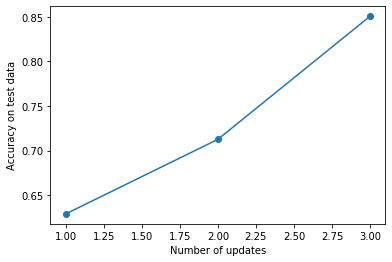

In [44]:
plt.plot([1, 2, 3], accuracies)
plt.scatter([1, 2, 3], accuracies)
plt.xlabel('Number of updates')
plt.ylabel('Accuracy on test data')

## Without Feature Extractor

### Train (10 points)

Now also add feature extractor network to your meta-network and repeat the same procedure like above cells just for inner loop update = 1.


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (25 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################

def train_complete(model, epochs, train_dataloader):

    meta_optim = optim.Adam(model.parameters(), lr=meta_outer_lr)
    log_every_iter = 50

    model.train()
    for epoch in range(epochs):

        running_loss = 0
        running_accuracy = 0
        for i, data in enumerate(train_dataloader):

            # Prepare input data
            x, y = data
            img_size = x.shape[1:]
            x = x.reshape((batch_size, -1, *img_size))
            y = y.reshape((batch_size, -1))
            for j in range(y.shape[0]):
                _, new_labels = torch.unique(y[j, :], return_inverse=True)
                y[j, :] = new_labels

            # To GPU
            x = x.to(device)
            y = y.to(device)
            supports = x[:, :N*support_size, :, :, :]
            queries = x[:, N*support_size:, :, :, :]
            support_labels = y[:, :N*support_size]
            query_labels = y[:, N*support_size:]

            # Forward Pass
            outputs = model(supports, support_labels, queries, fc=False)
            loss = F.cross_entropy(outputs.reshape((-1, N)), query_labels.reshape((-1, )))
            preds = outputs.argmax(dim=2)
            acc = ((preds == query_labels) * 1.0).mean()
            
            # Backward and parameter update
            meta_optim.zero_grad()
            loss.backward()
            meta_optim.step()

            # Keep metrics
            running_loss += loss.item()
            running_accuracy += acc.item()

            if i % log_every_iter == log_every_iter - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/log_every_iter:.3f}, \
                        accuracy = {running_accuracy/log_every_iter:.3f}')
                running_loss = 0.0
                running_accuracy = 0.0

def test_complete(model, test_dataloader):

    running_accuracy = 0
    model.eval()
    for data in test_dataloader:
        
        # Prepare input data
        x, y = data
        img_size = x.shape[1:]
        x = x.reshape((batch_size, -1, *img_size))
        y = y.reshape((batch_size, -1))
        for j in range(y.shape[0]):
            _, new_labels = torch.unique(y[j, :], return_inverse=True)
            y[j, :] = new_labels

        # To GPU
        x = x.to(device)
        y = y.to(device)
        supports = x[:, :N*support_size, :, :, :]
        queries = x[:, N*support_size:, :, :, :]
        support_labels = y[:, :N*support_size]
        query_labels = y[:, N*support_size:]

        # Forward Pass
        outputs = model(supports, support_labels, queries, fc=False)
        preds = outputs.argmax(dim=2)
        acc = ((preds == query_labels) * 1.0).mean()

        # Keep metrics
        running_accuracy += acc.item()

    acc = running_accuracy / len(test_dataloader)
    print('')
    print(f'Test accuracy is : {acc:.3f}')
    print('------------------------------------------')
    return acc

# -------------------------------------------

epochs = 10
config = [
    ('conv2d', [64, 1, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('flatten', []),
    ('linear', [N, 64])
]
print('Number of iterations in each epoch: {}'.format(len(train_dataloader)))
print('Number of testing iterations: {}'.format(len(test_dataloader)))
print('Training started ...')
model = Meta(config=config, inner_lr=meta_inner_lr, finetune_steps=1).to(device)
train_complete(model=model, epochs=epochs, train_dataloader=train_dataloader)
acc = test_complete(model=model, test_dataloader=test_dataloader)

#################################################################################
#                                   THE END                                     #
#################################################################################

Number of iterations in each epoch: 500
Number of testing iterations: 500
Training started ...
[1,    50] loss: 2.686,                         accuracy = 0.372
[1,   100] loss: 1.499,                         accuracy = 0.398
[1,   150] loss: 1.456,                         accuracy = 0.428
[1,   200] loss: 1.415,                         accuracy = 0.458
[1,   250] loss: 1.401,                         accuracy = 0.454
[1,   300] loss: 1.322,                         accuracy = 0.479
[1,   350] loss: 1.290,                         accuracy = 0.521
[1,   400] loss: 1.228,                         accuracy = 0.559
[1,   450] loss: 1.173,                         accuracy = 0.574
[1,   500] loss: 1.153,                         accuracy = 0.560
[2,    50] loss: 1.070,                         accuracy = 0.612
[2,   100] loss: 1.000,                         accuracy = 0.644
[2,   150] loss: 0.961,                         accuracy = 0.655
[2,   200] loss: 0.988,                         accuracy = 0

### Report (2.5 points)

Report accuracy of meta-test phase.

In [49]:
acc

0.809466686785221

## Compare and explain Results

Answer:

<br>
Looking at the plot for the "with feature extractor" part we realize that increasing the number of online optimization steps improves the performance of the model. This result is due to fact that with more optimization steps, the model has the capacity to better generalize and find more general meta parameters and consequently can find better task specific parameters during inference.
<br>
Furthermore in "without feature extractor" part we see more stable and steady accuracy improvement during test-time, something that is less observed in the previous part. This is due to the fact that when we have more meta-parameters the model will have more flexibility and will find more general meta-parameters. Because of this we can see that although we only have 1 gradient step, we still achive great results compared to the previous part with more gradient steps.
